This notebook is a technical exercise I worked on as part of an interview for a crypto trading firm. The exercises involve building simplified interfaces to parse order book data and calculate various quantities and derived properties.

I find technical interviews that involve live coding exercises to be really useful and really stressful. Live coding definitely triggers "performance anxiety" for me (when I was a kid I really hated presenting or playing an instrument in front of anyone, even teachers) - I felt self-councious and in this case I needed to use VSCode instead of my familiar Vim+Tmux setup. Consequently progress was really slow and bumpy. Tragically, I got really muddled trying to parse some json after the initial API request!

Whilst thinking about the problem and what code to write, I also needed to think about the following:
- How to communicate my thoughts
- How to optimize my output for an interview context (it's not a real problem involving tests, edge cases, scalability or performance considerations)
- How to use VSCode (and a mouse or trackpad). 

These additional considerations resulted in me writing code that got the job done.. but slowly. The code wasn't great. 

I was curious how much faster I'd be (and how much easier the exercise would seem) if I treated the exercise as a "take home" exercise instead of "live coding". Here are the results - it took a couple of hours, the ideas flowed more easily, and I could remember methods more accurately. I wish I didn't (still) get so self conscious!

Despite this, I think live coding interviews are a great way of assessing me - they get under my skin and show my worst sides as well as my best. If I'm going to work in a high paced and demanding role then the interview should also have those elements.

## Part 1 The Interface
### 1. Build an abstraction that, given a pair as an argument (ethusd in our case) fetches the latest orderbook and prints it.

In [1]:
import requests
import operator
import pprint
import pandas as pd
import time

pp = pprint.PrettyPrinter(indent=4)

In [2]:
def get_data(url):
    r = requests.get(url)
    data = r.json()
    return data.get('result')

In [3]:
#get_data("https://api.kraken.com/0/public/Depth?pair=ethusd")

## 2. Add some functionality that takes a side (bid or ask) and a price p as arguments, and returns the total volume available in the order book at p.

In [4]:
def calc_volume(ob_side, price):
    data = get_data("https://api.kraken.com/0/public/Depth?pair=ethusd")
    
    # side should be either "asks" or "bids"
    side = data["XETHZUSD"][ob_side]
    clean_data = []
    for i, j in enumerate(side):
        price_data = float(side[i][0])
        volume = float(side[i][1])
        clean_data.append((price_data, volume))

    # find all the items where first item is less than or equal to price
    index = 0
    volume = 0

    operate = {
        'bids': operator.ge,
        'asks': operator.le,
    }
    op = operate[ob_side]

    for i, j in enumerate(clean_data):
        if op(clean_data[i][0], price):
            index += 1
            volume += clean_data[i][1]
        else:
            break

    return volume

In [5]:
calc_volume("bids", 2470)

1056.4709999999998

In [6]:
calc_volume("asks", 2480)

0

## 3. Now add some (or modifies existing) functionality that takes a percentage and a side as arguments, and returns the volume available between the best price for that side, and that price +/- the percentage.

In [7]:
def slippage(ob_side, percent):
    data = get_data("https://api.kraken.com/0/public/Depth?pair=ethusd")
    
    # side should be either "asks" or "bids"
    side = data["XETHZUSD"][ob_side]
    clean_data = []
    for i, j in enumerate(side):
        price_data = float(side[i][0])
        volume = float(side[i][1])
        clean_data.append((price_data, volume))

    # find all the items where first item is less than or equal to price
    index = 0
    volume = 0

    starting_price = clean_data[0][0]
    # pprint.pprint(starting_price)

    if side == 'asks':
        percent *= -1

    op = operator.add if side == "ask" else operator.sub
    limit_price = op(starting_price, (starting_price * percent))
    # pp.pprint(f"limit_price: {limit_price}")
    operate = {
        'bids': operator.ge,
        'asks': operator.le,
    }
    op = operate[ob_side]

    for i, j in enumerate(clean_data):
        if op(clean_data[i][0], limit_price):
            index += 1
            volume += clean_data[i][1]
        else:
            break

    # pp.pprint(volume)
    return volume

In [8]:
slippage("bids", 0.01)

1666.9950000000003

## 4. Can you visualize the order book?

In [9]:
asks = get_data("https://api.kraken.com/0/public/Depth?pair=ethusd")['XETHZUSD']['asks']
bids = get_data("https://api.kraken.com/0/public/Depth?pair=ethusd")['XETHZUSD']['bids']

In [10]:
asks = pd.DataFrame(asks)
asks.columns = ['price', 'volume', 'timestamp']
asks['volume'] = asks['volume'].astype(float)
asks['cumulative'] = asks['volume'].cumsum()
asks.head()

,price,volume,timestamp,cumulative
0,2480.36000,0.591,1623670712,0.591
1,2480.48000,0.006,1623670590,0.597
2,2480.93000,0.007,1623670457,0.604
3,2480.96000,0.005,1623670684,0.609
4,2480.99000,0.172,1623670589,0.781


In [11]:
bids = pd.DataFrame(bids)
bids.columns = ['price', 'volume', 'timestamp']
bids['volume'] = bids['volume'].astype(float)
bids['cumulative'] = bids['volume'].cumsum()
bids.head()

,price,volume,timestamp,cumulative
0,2480.35000,21.903,1623670721,21.903
1,2480.34000,7.930,1623670720,29.833
2,2480.25000,0.250,1623670709,30.083
3,2480.22000,8.061,1623670715,38.144
4,2480.21000,16.113,1623670720,54.257


In [12]:
ob = pd.concat([bids[["price","cumulative"]], asks[["price","cumulative"]]], ignore_index=False)

In [13]:
ob.sort_values(by="price", inplace=True)
ob.set_index("price", inplace=True)

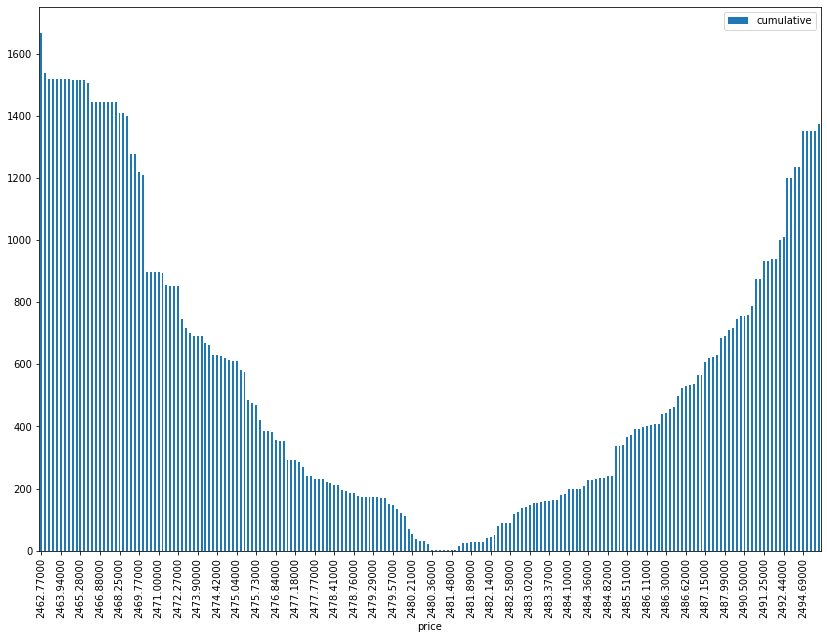

In [14]:
ax = ob.plot.bar(figsize=(14,10))
xticks = ax.xaxis.get_ticklocs()
xticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(xticks[::5]);
ax.xaxis.set_ticklabels(xticklabels[::5]);

# Part 2: Time-series
1. Build an abstraction that takes the following arguments:
    - A pair
    - A unit of time (t) that can be either "milliseconds", "seconds", "minutes" or "hours".
    - A number of time units (n)  

   Given these arguments, it should fetch and store the order book for the pair every n t. For example: if t = "second" and n = 3, it should fetch the order book every second for a total of 3 times.



In [15]:
def time_series(pair, tunit, n):
    base_url = f"https://api.kraken.com/0/public/Depth?pair={pair}"
    pair_mod = "X"+pair[0:3].upper()+"Z"+pair[3:].upper()
    results = {}
    
    timeunits = {
        "s": 1,
        "m": 60*1,
        "ms": 0.001,
    }
    realtime = timeunits[tunit]
    
    for i in range(n):
        print(f"getting snapshot {i+1} of {n}")
        r = requests.get(base_url)
        data = r.json()
        print(hash(frozenset(r)))
        results[i] = data.get('result')[pair_mod]
        time.sleep(n*realtime) # had to modify by multiplying by n so that api is more likely to return different data set.
    
    print("done!")
    return results

In [16]:
results = time_series("ethusd", "s", 3)

getting snapshot 1 of 3
-1526417027600069276
getting snapshot 2 of 3
-8189240544199034758
getting snapshot 3 of 3
-7237732313600249416
done!


_We see that the hash of the api response is sometimes the same, so we would expect there to be no volume change between these identical snapshots._

In [17]:
#results

### Now extend your code to compare the order books you've fetched to each other. Given the name of a pair, n, t and a price p, determine how much the total volume available at p has changed between each "frame", and between the first and last "frame".

In [18]:
# redefine "calc_volume" function from above to make data an input param
def calc_volume(data, ob_side, price):
    
    # side should be either "asks" or "bids"
    side = data[ob_side]
    clean_data = []
    for i, j in enumerate(side):
        price_data = float(side[i][0])
        volume = float(side[i][1])
        clean_data.append((price_data, volume))

    # find all the items where first item is less than or equal to price
    index = 0
    volume = 0

    operate = {
        'bids': operator.ge,
        'asks': operator.le,
    }
    op = operate[ob_side]

    for i, j in enumerate(clean_data):
        if op(clean_data[i][0], price):
            index += 1
            volume += clean_data[i][1]
        else:
            break

    return volume

In [19]:
def snapshot_compare(results, ob_side, price):
    snap_vol = []
    for key in results:
        result = calc_volume(results[key], ob_side, price)
        snap_vol.append(result)
        
    total_change = round(snap_vol[-1] - snap_vol[0])
    incremental_changes = [round(snap_vol[i+1] - snap_vol[i]) for i, j in enumerate(snap_vol) if i < len(snap_vol)-1]
    print(f"vol in each snapshot: {snap_vol}")
    print(f"incremental: {incremental_changes}")
    print(f"total (diff between last and first): {total_change}")

In [20]:
results = time_series("ethusd", "s", 3)

getting snapshot 1 of 3
-7237732313600249416
getting snapshot 2 of 3
-7821156310868186692
getting snapshot 3 of 3
-7821156310868186692
done!


In [21]:
#results

In [23]:
snapshot_compare(results, "bids", 2470)

vol in each snapshot: [981.6129999999997, 975.4639999999998, 975.4639999999998]
incremental: [-6, 0]
total (diff between last and first): -6


### Finally, can you think of an efficient way to get a "diff" of two frames? For example, can you think of a way to determine at which price the volume changed the most?

Quick idea:
- for each side of each order book, group the orders into buckets with a certain width, e.g. if the lowest ask is 2450, group all the asks from 2450 to 2451, then from 2451 to 2452, etc. Do this for both sides of each order book you collect.
- you then have multiple aggregated order books with the same indexes.
- compare the volumes at the same index across each orderbook


Additional considerations:
- need to force the lowest ask or max bid to be the same in each order book snapshot. 
- need to deal with large spreads
- comparisons where one side has 0 volume should be marked as suspicious and investigated further to iterate a better solution.
- need to present negative volumes changes correctly